# Deep Learning

I will use deep learning with Word2Vec, GloVe and Fasttext. Let's start with Word2Vec:

## Word2Vec

The basic idea of word embedding is words that occur in similar context tend to be closer to each other in vector space. 
Word Embedding is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions. Word embeddings can be generated using various methods like neural networks, co-occurrence matrix, probabilistic models, etc.

Word2Vec consists of models for generating word embedding. These models are shallow two layer neural networks having one input layer, one hidden layer and one output layer. Word2Vec utilizes two architectures :

CBOW (Continuous Bag of Words) : CBOW model predicts the current word given context words within specific window. The input layer contains the context words and the output layer contains the current word. The hidden layer contains the number of dimensions in which we want to represent current word present at the output layer.

Skip Gram : Skip gram predicts the surrounding context words within specific window given current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer.

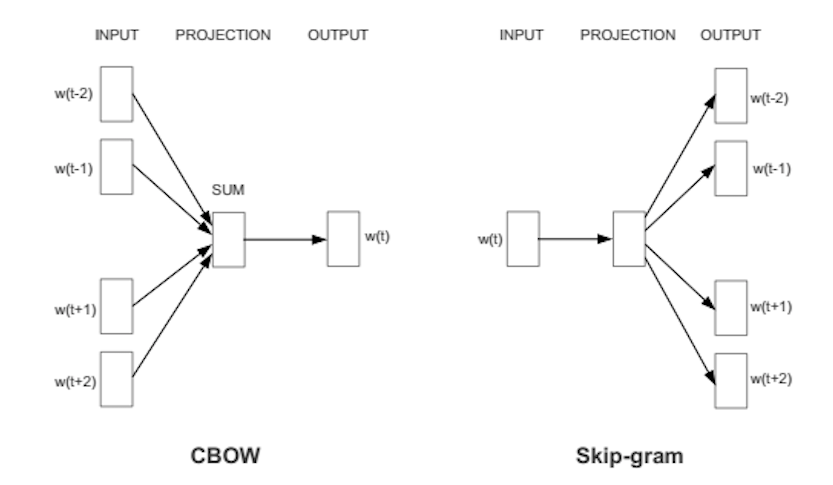

For generating word vectors in Python, modules needed are nltk and gensim.

In [50]:
# import necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import gensim
import nltk
import keras

from gensim.models.word2vec import Word2Vec
from nltk import word_tokenize
#nltk.download('stopwords')
import tensorflow as tf
import re

from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LSTM
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

import warnings
warnings.filterwarnings(action='ignore')
#warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [51]:
# read the file to a DataFrame
df = pd.read_csv('2_explored.csv', index_col=0)
df.head()

,sex,rating,product,review,review_date,reviewer_id,clean_text,review_month,review_length
0,f,1,service,"İstanbul'da en sevdiğim mekan, analog dostu. M...",2017-03-08,44720,istanbulda sevdigim mekan analog dostu minicik...,Mar,21
1,f,1,studio,KESİNLİKLE ÇOK GÜZEL BİR STÜDYO,2017-10-17,46945,kesinlikle guzel studyo,Oct,5
2,f,1,service,Burayı hep sevdim,2017-01-03,92805,buray sevdim,Jan,3
3,m,1,wedding,"Düğün fotoğrafı için gitmiştik, çok güzel çeki...",2017-01-19,51670,dugun gitmistik guzel cekimler yaptlar hazrlad...,Jan,19
4,f,0,service,O kadar iyi diil tabi. Isim var sadece,2017-11-05,79719,kadar iyi diil tabi isim var sadece,Nov,9


I need to do my own train test split here:

In [52]:
cleaned_values = df.clean_text.values
cleaned_values.shape

(1063,)

In [53]:
X_train_cleaned_values = cleaned_values[:800]
X_test_cleaned_values = cleaned_values[800:]


rating_values = df['rating'].values
y_test = rating_values[800:]
y_tr = rating_values[:800]
print(y_tr.shape)
y_tr[:3]

(800,)


array([1, 1, 1], dtype=int64)

In [54]:
y_train = to_categorical(y_tr)
print(y_train.shape)
y_train[:3]

(800, 2)


array([[0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [55]:
X_train_cleaned_values[:1]

array(['istanbulda sevdigim mekan analog dostu minicik dukkan butun herkesin yuzu guluyor iyi varlar'],
      dtype=object)

I tokenize the training set features before applying Word2Vec.

In [56]:
X_train_tokenized = [nltk.word_tokenize(text) for text in X_train_cleaned_values]

In [57]:
X_train_tokenized[:1]

[['istanbulda',
  'sevdigim',
  'mekan',
  'analog',
  'dostu',
  'minicik',
  'dukkan',
  'butun',
  'herkesin',
  'yuzu',
  'guluyor',
  'iyi',
  'varlar']]

In [58]:
len(X_train_tokenized)

800

In [59]:
number_features = 1000
# tokenize also the test set features
X_test_tokenized = [nltk.word_tokenize(text)
                       for text in X_test_cleaned_values]

In [60]:
# train word2vec model using gensim
w2v = Word2Vec(X_train_tokenized, sg=1, window=3, size=number_features,
                 min_count=1, workers=3, iter=50 , sample=0.01)

The following function helps compute averaged word vector representations for any corpus of text documents.

In [61]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

I will use this function to generate averaged word vector representations on the dataset.

In [62]:
# generate averaged word vector features from word2vec model
X_train_w2v = averaged_word2vec_vectorizer(corpus=X_train_tokenized, model=w2v, num_features=number_features)
X_test_w2v = averaged_word2vec_vectorizer(corpus=X_test_tokenized, model=w2v, num_features=number_features)

In [63]:
print('Word2Vec model:> Train features shape:', X_train_w2v.shape, ' Test features shape:', X_test_w2v.shape)

Word2Vec model:> Train features shape: (800, 1000)  Test features shape: (263, 1000)


Now, I will define a function for building a deep neural network architecture that I will use for Word2Vec and GloVe.

In [64]:
def deep_neural_network(num_input_features):
    
    '''This function builds a deep neural network architecture with the given number of input features'''
    
    # get number of nodes in input layer
    # n_cols = predictors.shape[1]
    n_cols = num_input_features
    
    # Set up the model: model
    model = Sequential()
    
    # Add the first layer
    model.add(Dense(1000, activation = 'relu', kernel_initializer='glorot_uniform', input_shape = (n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Add the second layer
    model.add(Dense(1000, activation = 'relu', kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Add the third layer
    model.add(Dense(1000, activation = 'relu', kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Add the output layer
    model.add(Dense(2, activation = 'softmax'))
    
    # Compile the model
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [65]:
w2v_dnn = deep_neural_network(num_input_features=number_features)

In [66]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=30)

# Fit the model
w2v_dnn.fit(X_train_w2v, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 2s 2ms/step - loss: 1.1578 - accuracy: 0.6141 - val_loss: 0.5094 - val_accuracy: 0.7688
Epoch 2/100
640/640 [==============================] - 1s 1ms/step - loss: 0.6689 - accuracy: 0.7141 - val_loss: 0.5679 - val_accuracy: 0.7688
Epoch 3/100
640/640 [==============================] - 1s 1ms/step - loss: 0.5536 - accuracy: 0.7609 - val_loss: 0.6302 - val_accuracy: 0.7688
Epoch 4/100
640/640 [==============================] - 1s 1ms/step - loss: 0.4474 - accuracy: 0.7891 - val_loss: 0.6250 - val_accuracy: 0.7688
Epoch 5/100
640/640 [==============================] - 1s 1ms/step - loss: 0.4074 - accuracy: 0.8141 - val_loss: 0.6891 - val_accuracy: 0.7688
Epoch 6/100
640/640 [==============================] - 1s 1ms/step - loss: 0.4598 - accuracy: 0.7906 - val_loss: 0.6198 - val_accuracy: 0.7688
Epoch 7/100
640/640 [==============================] - 1s 1ms/step - loss: 0.4141 - accuracy: 0.

In [67]:
y_pred_w2v = w2v_dnn.predict_classes(X_test_w2v)

In [68]:
y_pred_w2v.shape

(263,)

In [69]:
y_test.shape

(263,)

In [70]:
print (classification_report(y_test, y_pred_w2v))

              precision    recall  f1-score   support

           0       0.53      0.24      0.33        71
           1       0.77      0.92      0.84       192

    accuracy                           0.74       263
   macro avg       0.65      0.58      0.58       263
weighted avg       0.70      0.74      0.70       263



In [71]:
print(accuracy_score(y_test, y_pred_w2v))

0.7376425855513308


In [72]:
history_w2v = w2v_dnn.fit(X_train_w2v, y_train, epochs=100, batch_size=200, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 0s 389us/step - loss: 0.3040 - accuracy: 0.8681 - val_loss: 0.3510 - val_accuracy: 0.8500
Epoch 2/100
720/720 [==============================] - 0s 391us/step - loss: 0.2667 - accuracy: 0.8889 - val_loss: 0.3623 - val_accuracy: 0.8625
Epoch 3/100
720/720 [==============================] - 0s 390us/step - loss: 0.2578 - accuracy: 0.8875 - val_loss: 0.4181 - val_accuracy: 0.8375
Epoch 4/100
720/720 [==============================] - 0s 382us/step - loss: 0.2578 - accuracy: 0.8917 - val_loss: 0.4558 - val_accuracy: 0.8375
Epoch 5/100
720/720 [==============================] - 0s 380us/step - loss: 0.2332 - accuracy: 0.9083 - val_loss: 0.3943 - val_accuracy: 0.8625
Epoch 6/100
720/720 [==============================] - 0s 386us/step - loss: 0.2429 - accuracy: 0.8986 - val_loss: 0.3891 - val_accuracy: 0.8625
Epoch 7/100
720/720 [==============================] - 0s 391us/step - loss: 0.2172 -

Epoch 57/100
720/720 [==============================] - 0s 390us/step - loss: 0.1273 - accuracy: 0.9514 - val_loss: 0.5473 - val_accuracy: 0.8000
Epoch 58/100
720/720 [==============================] - 0s 369us/step - loss: 0.1394 - accuracy: 0.9403 - val_loss: 0.4967 - val_accuracy: 0.8375
Epoch 59/100
720/720 [==============================] - 0s 391us/step - loss: 0.1259 - accuracy: 0.9486 - val_loss: 0.4654 - val_accuracy: 0.8625
Epoch 60/100
720/720 [==============================] - 0s 370us/step - loss: 0.1484 - accuracy: 0.9431 - val_loss: 0.5185 - val_accuracy: 0.8250
Epoch 61/100
720/720 [==============================] - 0s 392us/step - loss: 0.1437 - accuracy: 0.9347 - val_loss: 0.5682 - val_accuracy: 0.8250
Epoch 62/100
720/720 [==============================] - 0s 370us/step - loss: 0.1302 - accuracy: 0.9500 - val_loss: 0.4813 - val_accuracy: 0.8125
Epoch 63/100
720/720 [==============================] - 0s 391us/step - loss: 0.1274 - accuracy: 0.9486 - val_loss: 0.4804 -

I will define a function which plots accuracy and loss scores of test and validation sets given history of a model run.

In [73]:
def plot_scores(history):
    
    '''This function plots accuracy and loss scores of test and validation sets given history of a model run'''
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

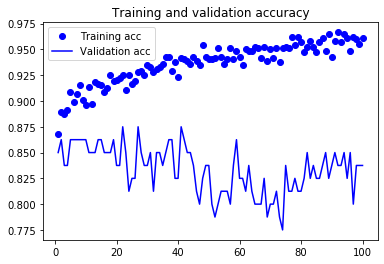

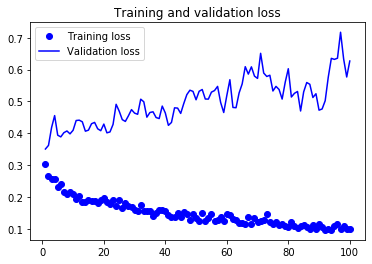

In [74]:
plot_scores(history_w2v)

It's time to look at GloVe:

## GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.    

Glove produces dense vector embeddings of words, where words that occur together are close in the resulting vector space.

While this produces embeddings which are similar to word2vec (which has a great python implementation in gensim), the method is different: GloVe produces embeddings by factorizing the logarithm of the corpus word co-occurrence matrix.

The spacy library provided 300-dimensional word vectors trained on the Common Crawl corpus using the GloVe model. They provide a simple standard interface to get feature vectors of size 300 for each word as well as the averaged feature vector of a complete text document. The following snippet leverages spacy to get the GloVe embeddings for our datasets.  

Producing the embeddings is a two-step process: creating a co-occurrence matrix from the corpus, and then using it to produce the embeddings. The Corpus class helps in constructing a corpus from an interable of tokens; the Glove class trains the embeddings (with a sklearn-esque API).

In [75]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [77]:
# feature engineering with GloVe model
X_train_nlp = [nlp(item) for item in X_train_cleaned_values]
X_train_glove = np.array([item.vector for item in X_train_nlp])

X_test_nlp = [nlp(item) for item in X_test_cleaned_values]
X_test_glove = np.array([item.vector for item in X_test_nlp])

In [78]:
print('GloVe model:> Train features shape:', X_train_glove.shape, ' Test features shape:', X_test_glove.shape)

GloVe model:> Train features shape: (800, 96)  Test features shape: (263, 96)


I can now proceed to build and train a deep neural network on these features.

I will be using a fully-connected four layer deep neural network (multi-layer perceptron or deep NN) for our model. We do not count the input layer usually in any deep architecture, hence our model will consist of three hidden layers of 1000 neurons or units and one output layer with two units that will be used to either predict a positive (good) or negative (bad) sentiment based on the input layer features. 

In [79]:
glove_dnn = deep_neural_network(num_input_features=96)

In [80]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=30)

# Fit the model
glove_dnn.fit(X_train_glove, y_train, epochs=100, validation_split=0.2, 
              callbacks=[early_stopping_monitor], shuffle=True)

Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 2ms/step - loss: 1.4723 - accuracy: 0.5891 - val_loss: 0.6158 - val_accuracy: 0.6938
Epoch 2/100
640/640 [==============================] - 1s 1ms/step - loss: 0.8558 - accuracy: 0.7000 - val_loss: 0.5475 - val_accuracy: 0.7688
Epoch 3/100
640/640 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.7922 - val_loss: 0.6311 - val_accuracy: 0.7437
Epoch 4/100
640/640 [==============================] - 1s 1ms/step - loss: 0.3327 - accuracy: 0.8391 - val_loss: 0.6714 - val_accuracy: 0.7750
Epoch 5/100
640/640 [==============================] - 1s 1ms/step - loss: 0.2397 - accuracy: 0.8969 - val_loss: 0.7606 - val_accuracy: 0.7688
Epoch 6/100
640/640 [==============================] - 1s 1ms/step - loss: 0.2193 - accuracy: 0.9047 - val_loss: 0.7212 - val_accuracy: 0.7688
Epoch 7/100
640/640 [==============================] - 1s 1ms/step - loss: 0.1865 - accuracy: 0.

In [81]:
y_pred_glove = glove_dnn.predict_classes(X_test_glove)

In [82]:
print (classification_report(y_test, y_pred_glove))

              precision    recall  f1-score   support

           0       0.56      0.25      0.35        71
           1       0.77      0.93      0.84       192

    accuracy                           0.75       263
   macro avg       0.67      0.59      0.60       263
weighted avg       0.71      0.75      0.71       263



In [83]:
print(accuracy_score(y_test, y_pred_glove))

0.7452471482889734


In [84]:
history_glove = glove_dnn.fit(X_train_glove, y_train, epochs=100, batch_size=200, 
              shuffle=True, validation_split=0.1, verbose=1)

Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 0s 283us/step - loss: 0.2502 - accuracy: 0.9347 - val_loss: 0.9429 - val_accuracy: 0.7625
Epoch 2/100
720/720 [==============================] - 0s 288us/step - loss: 0.1952 - accuracy: 0.9486 - val_loss: 1.0284 - val_accuracy: 0.7125
Epoch 3/100
720/720 [==============================] - 0s 306us/step - loss: 0.1217 - accuracy: 0.9653 - val_loss: 1.1264 - val_accuracy: 0.6875
Epoch 4/100
720/720 [==============================] - 0s 299us/step - loss: 0.1104 - accuracy: 0.9583 - val_loss: 1.0573 - val_accuracy: 0.7125
Epoch 5/100
720/720 [==============================] - 0s 288us/step - loss: 0.0587 - accuracy: 0.9819 - val_loss: 1.0534 - val_accuracy: 0.7625
Epoch 6/100
720/720 [==============================] - 0s 302us/step - loss: 0.0565 - accuracy: 0.9806 - val_loss: 1.0510 - val_accuracy: 0.7750
Epoch 7/100
720/720 [==============================] - 0s 296us/step - loss: 0.0416 -

Epoch 57/100
720/720 [==============================] - 0s 290us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0380 - val_accuracy: 0.8625
Epoch 58/100
720/720 [==============================] - 0s 290us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.0422 - val_accuracy: 0.8500
Epoch 59/100
720/720 [==============================] - 0s 295us/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.0467 - val_accuracy: 0.8500
Epoch 60/100
720/720 [==============================] - 0s 287us/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 1.0499 - val_accuracy: 0.8500
Epoch 61/100
720/720 [==============================] - 0s 294us/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.0510 - val_accuracy: 0.8625
Epoch 62/100
720/720 [==============================] - 0s 297us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0525 - val_accuracy: 0.8625
Epoch 63/100
720/720 [==============================] - 0s 301us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0580 -

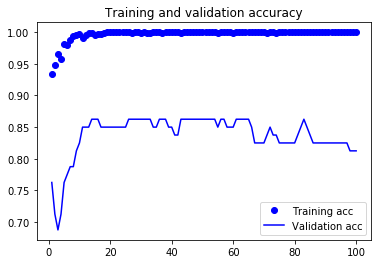

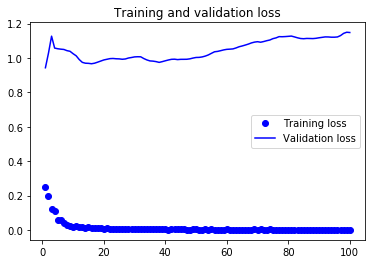

In [85]:
plot_scores(history_glove)

## Inspecting Similar Words with FastText

FastText is a library created by the Facebook Research Team for efficient learning of word representations and sentence classification.  

The main principle behind fastText is that the morphological structure of a word carries important information about the meaning of the word, which is not taken into account by traditional word embeddings, which train a unique word embedding for every individual word. This is especially significant for morphologically rich languages (German, Turkish) in which a single word can have a large number of morphological forms, each of which might occur rarely, thus making it hard to train good word embeddings.  

FastText differs in the sense that word vectors a.k.a word2vec treats every single word as the smallest unit whose vector representation is to be found but FastText assumes a word to be formed by a n-grams of character, for example, sunny is composed of [sun, sunn,sunny],[sunny,unny,nny]  etc, where n could range from 1 to the length of the word. This new representation of word by fastText provides the following benefits over word2vec or glove.

1. It is helpful to find the vector representation for rare words. Since rare words could still be broken into character n-grams, they could share these n-grams with the common words. For example, for a model trained on a news dataset, the medical terms eg: diseases can be the rare words.  
2. It can give the vector representations for the words not present in the dictionary (OOV words) since these can also be broken down into character n-grams. word2vec and glove both fail to provide any vector representations for words not in the dictionary.
For example, for a word like stupedofantabulouslyfantastic, which might never have been in any corpus, gensim might return any two of the following solutions – a) a zero vector    or      b) a random vector with low magnitude. But FastText can produce vectors better than random by breaking the above word in chunks and using the vectors for those chunks to create a final vector for the word. In this particular case, the final vector might be closer to the vectors of fantastic and fantabulous.
3. Character n-grams embeddings tend to perform superior to word2vec and glove on smaller datasets.

In [86]:
from gensim.models.fasttext import FastText
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in cleaned_values]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 2   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)
                    
                    
# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['guzel', 'iyi', 'tavsiye', 'kotu', 'pahal']}
similar_words

{'guzel': ['guzeldi', 'nezih', 'gunumuze', 'gunumuzun', 'gunumuzde'],
 'iyi': ['semtin', 'ziyaret', 'civarda', 'civardaki', 'servis'],
 'tavsiye': ['siddetle', 'tavsiyesi', 'oneriyorum', 'diliyorum', 'ekonomik'],
 'kotu': ['etmisler', 'ancak', 'rezil', 'bukadar', 'lazmd'],
 'pahal': ['pahaldr', 'pahali', 'asr', 'otopark', 'biraz']}

## Inspecting Similar Words with Word2Vec

In [87]:
word2vec = gensim.models.Word2Vec(X_train_tokenized, size=100, window=10, min_count=2)

In [88]:
words = list(word2vec.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 1044


In [89]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['guzel', 'iyi', 'tavsiye', 'kotu', 'pahal']}
similar_words

{'guzel': ['hic', 'sonra', 'olarak', 'oldu', 'sizi'],
 'iyi': ['hic', 'bile', 'sonra', 'sekilde', 'teslim'],
 'tavsiye': ['zaman', 'memnun', 'hic', 'kesinlikle', 'foto'],
 'kotu': ['guzel', 'sonra', 'size', 'kesinlikle', 'gercekten'],
 'pahal': ['cekim', 'guler', 'sonra', 'gun', 'gerek']}

As expected, FastText performs better than Word2Vec in finding similar words in a morphologically rich language (Turkish). 

In [90]:
# Most similar words by score to a given word 

word2vec.wv.most_similar('kaliteli', topn =3)

[('foto', 0.5399898290634155),
 ('guzel', 0.5226943492889404),
 ('var', 0.5206670165061951)]

In [91]:
# check similarity score
print(word2vec.wv.similarity('tavsiye', 'memnun'))

0.58027315


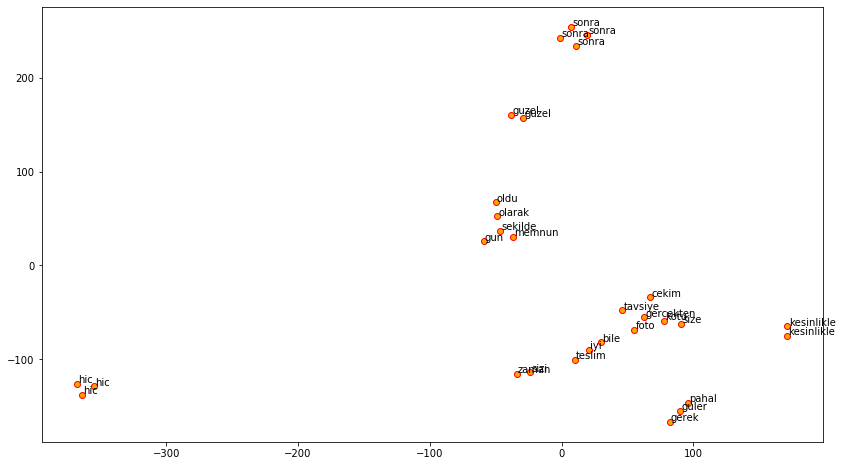

In [92]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

## Convolutional Neural Network (CNN)

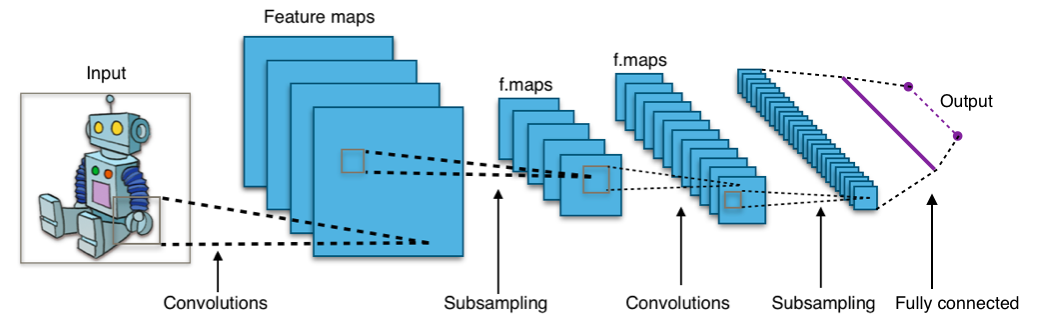

<center>Figure from Wikimedia

The basic CNN structure is as follows: Convolution -> Pooling -> Convolution -> Pooling -> Fully Connected Layer -> Output

Convolution is the act of taking the original data, and creating feature maps from it.Pooling is down-sampling, most often in the form of "max-pooling," where we select a region, and then take the maximum value in that region, and that becomes the new value for the entire region. Fully Connected Layers are typical neural networks, where all nodes are "fully connected." The convolutional layers are not fully connected like a traditional neural network.

Preprocessing  

To prepare text data for our deep learning model, we transform each review into a sequence. Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the Tokenizer

In [93]:
# instantiate tokenizer
tok = Tokenizer()

# fit the tokenizer on the documents
tok.fit_on_texts(X_train_cleaned_values)

X_train_sequences = tok.texts_to_sequences(X_train_tokenized)
X_test_sequences = tok.texts_to_sequences(X_test_tokenized)

vocabulary_size = len(tok.word_counts)
print("Vocabulary size={}".format(vocabulary_size))
print("Number of Documents={}".format(tok.document_count))

Vocabulary size=3518
Number of Documents=800


Sequence Normalization  

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we padd them with zeros which longer ones are truncated  

In [94]:
max_seq = max([len(x) for x in X_train_sequences])
max_seq

243

In [95]:
# pad dataset to a maximum review length in words
X_train_cnn = sequence.pad_sequences(X_train_sequences, maxlen=max_seq)
X_test_cnn = sequence.pad_sequences(X_test_sequences, maxlen=max_seq)

In [96]:
X_train_cnn.shape[0]

800

Prepare the Model  

Since textual data is a sequence of words, we utilize 1D convolutions to scan through the sentences. The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [97]:
embedding_size = 50

In [98]:
# build the model
model = Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=max_seq))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1000, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 243, 50)           175950    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 243, 32)           4832      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 243, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 121, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              3873000   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1000)             

In [99]:
# Fit the model
model.fit(X_train_cnn, y_tr, validation_split=0.2, epochs=100, batch_size=200, verbose=1)

Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 1s 888us/step - loss: 0.5813 - accuracy: 0.6422 - val_loss: 0.7071 - val_accuracy: 0.7625
Epoch 2/100
640/640 [==============================] - 0s 653us/step - loss: 0.5851 - accuracy: 0.7969 - val_loss: 0.5295 - val_accuracy: 0.7625
Epoch 3/100
640/640 [==============================] - 0s 676us/step - loss: 0.4940 - accuracy: 0.8031 - val_loss: 0.5397 - val_accuracy: 0.7750
Epoch 4/100
640/640 [==============================] - 0s 691us/step - loss: 0.4844 - accuracy: 0.8109 - val_loss: 0.5261 - val_accuracy: 0.7750
Epoch 5/100
640/640 [==============================] - 0s 663us/step - loss: 0.4471 - accuracy: 0.8125 - val_loss: 0.5476 - val_accuracy: 0.7750
Epoch 6/100
640/640 [==============================] - 0s 701us/step - loss: 0.4273 - accuracy: 0.8266 - val_loss: 0.5201 - val_accuracy: 0.7812
Epoch 7/100
640/640 [==============================] - 0s 702us/step - loss: 0.3902 

In [100]:
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 77.19%


In [101]:
y_pred_cnn = model.predict_classes(X_test_cnn)

In [102]:
print (classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.57      0.62      0.59        71
           1       0.85      0.83      0.84       192

    accuracy                           0.77       263
   macro avg       0.71      0.72      0.72       263
weighted avg       0.78      0.77      0.77       263



In [103]:
# Fit the model
history_cnn = model.fit(X_train_cnn, y_tr, validation_split=0.2, epochs=100, batch_size=200, verbose=1)

Train on 640 samples, validate on 160 samples
Epoch 1/100
640/640 [==============================] - 0s 692us/step - loss: 1.1156e-04 - accuracy: 1.0000 - val_loss: 0.7686 - val_accuracy: 0.8188
Epoch 2/100
640/640 [==============================] - 0s 727us/step - loss: 1.0872e-04 - accuracy: 1.0000 - val_loss: 0.7690 - val_accuracy: 0.8188
Epoch 3/100
640/640 [==============================] - 0s 701us/step - loss: 1.0655e-04 - accuracy: 1.0000 - val_loss: 0.7713 - val_accuracy: 0.8188
Epoch 4/100
640/640 [==============================] - 0s 728us/step - loss: 1.0437e-04 - accuracy: 1.0000 - val_loss: 0.7730 - val_accuracy: 0.8188
Epoch 5/100
640/640 [==============================] - 0s 706us/step - loss: 1.0224e-04 - accuracy: 1.0000 - val_loss: 0.7742 - val_accuracy: 0.8188
Epoch 6/100
640/640 [==============================] - 0s 702us/step - loss: 1.0036e-04 - accuracy: 1.0000 - val_loss: 0.7761 - val_accuracy: 0.8188
Epoch 7/100
640/640 [==============================] - 0s 72

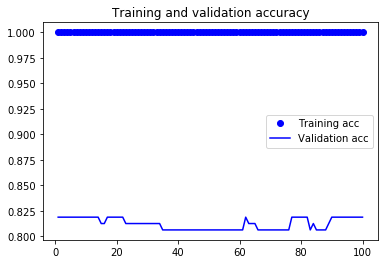

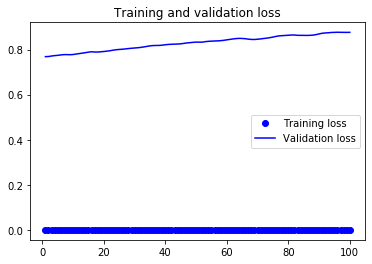

In [104]:
plot_scores(history_cnn)

## Recurrent Neural Network (RNN)

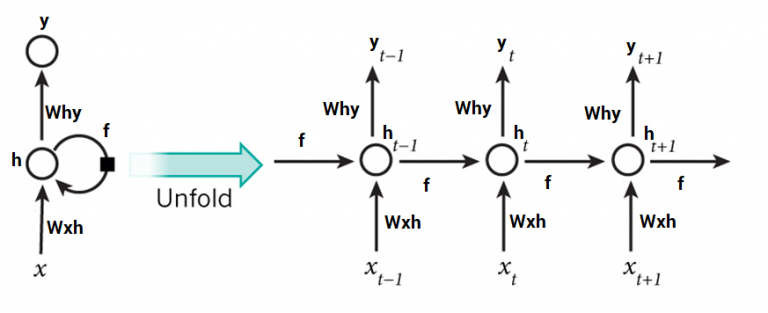

Recurrent Neural Networks (RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer. The main and most important feature of RNN is Hidden state, which remembers some information about a sequence.  

RNNs are a type of artificial neural network that add additional weights to the network to create cycles in the network graph in an effort to maintain an internal state.

### Advantages of Recurrent Neural Network  

An RNN remembers each and every information through time. It is useful in time series prediction only because of the feature to remember previous inputs as well. This is called Long Short Term Memory.
Recurrent neural network are even used with convolutional layers to extend the effective pixel neighborhood.

### Disadvantages of Recurrent Neural Network

Gradient vanishing and exploding problems.
Training an RNN is a very difficult task.
It cannot process very long sequences if using tanh or relu as an activation function.

### Long short-term memory (LSTM)

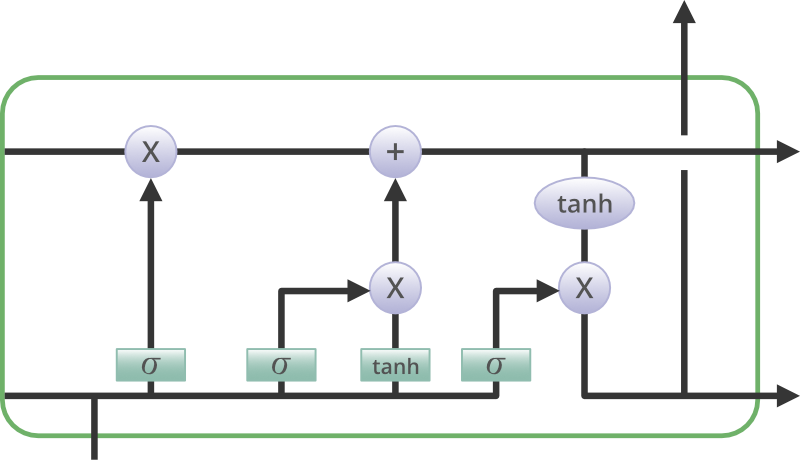

To solve the problem of Vanishing and Exploding Gradients in a deep Recurrent Neural Network, many variations were developed. One of the most famous of them is the Long Short Term Memory Network(LSTM). In concept, an LSTM recurrent unit tries to “remember” all the past knowledge that the network is seen so far and to “forget” irrelevant data. This is done by introducing different activation function layers called “gates” for different purposes. Each LSTM recurrent unit also maintains a vector called the Internal Cell State which conceptually describes the information that was chosen to be retained by the previous LSTM recurrent unit.

We would need to create a word to index vocabulary mapping for representing each tokenized text review in a numeric form. We also need to create a numeric mapping for the padding term which we shall call PAD_INDEX and assign it the numeric index of 0. For unknown terms, in case they are encountered later on in the test dataset or newer, previously unseen reviews, we would need to assign it to some index too. This would be because we will vectorize, engineer features, and build models only on the training data.

If some new term should come up in the future (which was originally not a part of the model training), we will consider it as an out of vocabulary (OOV) term and assign it to a constant index (we will name this term NOT_FOUND_INDEX and assign it the index of vocab_size+1).

In [105]:
# build word to index vocabulary
token_counter = Counter([token for review in X_train_tokenized for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)

# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 3521
Sample slice of vocabulary map: {'guluyor': 11, 'iyi': 12, 'varlar': 13, 'kesinlikle': 14, 'guzel': 15, 'studyo': 16, 'buray': 17, 'sevdim': 18, 'dugun': 19, 'gitmistik': 20}


I will now encode the tokenized text reviews based on the previous vocabulary map. 

In [106]:
# get max length of train corpus
max_len = np.max([len(review) for review in X_train_tokenized])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
X_train_lstm = [[vocab_map[token] for token in tokenized_review] for tokenized_review in X_train_tokenized]
X_train_lstm = sequence.pad_sequences(X_train_lstm, maxlen=max_len) # pad 

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
X_test_lstm = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in X_test_tokenized]
X_test_lstm = sequence.pad_sequences(X_test_lstm, maxlen=max_len)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', X_train_lstm.shape, ' Test review vectors shape:', X_test_lstm.shape)

Max length of train review vectors: 243
Train review vectors shape: (800, 243)  Test review vectors shape: (263, 243)


From the preceding code snippet and the output, it is clear that we encoded each text review into a numeric sequence vector so that the size of each review vector is 243, which is basically the maximum length of reviews from the training dataset. We pad shorter reviews and truncate extra tokens from longer reviews such that the shape of each review is constant as depicted in the output. We can now proceed with Step 3 and a part of Step 4 of the classification workflow by introducing the Embedding layer and coupling it with the deep network architecture based on LSTMs.

Build the LSTM Model Architecture
The Embedding layer helps us generate the word embeddings from scratch. This layer is also initialized with some weights initially and this gets updated based on our optimizer similar to weights on the neuron units in other layers when the network tries to minimize the loss in each epoch. Thus, the embedding layer tries to optimize its weights such that we get the best word embeddings which will generate minimum error in the model and also capture semantic similarity and relationships among words.

These dense word embeddings are then passed to the LSTM layer having 640 units. LSTMs basically try to overcome the shortcomings of RNN models especially with regard to handling long term dependencies and problems which occur when the weight matrix associated with the units (neurons) become too small (leading to vanishing gradient) or too large (leading to exploding gradient).

In [107]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=1280, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(640, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 243, 1280)         4506880   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 243, 1280)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 640)               4917760   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 641       
Total params: 9,425,281
Trainable params: 9,425,281
Non-trainable params: 0
_________________________________________________________________
None


The RNN units usually have a chain of repeating modules such that the module has a simple structure of having maybe one layer with the tanh activation. LSTMs are also a special type of RNN, having a similar structure but the LSTM unit has four neural network layers instead of just one. The final layer in our deep network is the Dense layer with 1 unit and the sigmoid activation function. 

In [108]:
# train
batch_size = 20
history_lstm = model.fit(X_train_lstm, y_tr, epochs=10, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 170s 236ms/step - loss: 0.5007 - accuracy: 0.7750 - val_loss: 0.3452 - val_accuracy: 0.8375
Epoch 2/10
720/720 [==============================] - 199s 277ms/step - loss: 0.2394 - accuracy: 0.9167 - val_loss: 0.3158 - val_accuracy: 0.8625
Epoch 3/10
720/720 [==============================] - 209s 291ms/step - loss: 0.0591 - accuracy: 0.9819 - val_loss: 0.2677 - val_accuracy: 0.8625
Epoch 4/10
720/720 [==============================] - 219s 304ms/step - loss: 0.0332 - accuracy: 0.9903 - val_loss: 0.2361 - val_accuracy: 0.8875
Epoch 5/10
720/720 [==============================] - 232s 322ms/step - loss: 0.0176 - accuracy: 0.9931 - val_loss: 0.3026 - val_accuracy: 0.8625
Epoch 6/10
720/720 [==============================] - 253s 351ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.3552 - val_accuracy: 0.8375
Epoch 7/10
720/720 [==============================] - 246s 342ms/step - loss: 0

Training LSTMs on CPU is notoriously slow. A cloud-based environment like Google Cloud Platform or AWS on GPU would take me approximately less than an hour to train the same model.

Based on the preceding output, we can see that just with five epochs we have decent validation accuracy but the training accuracy starts shooting up indicating some over-fitting might be happening. Ways to overcome this include adding more data or by increasing the drouput rate.

In [109]:
y_pred_lstm = model.predict_classes(X_test_lstm)

In [110]:
# Final evaluation of the model
scores = model.evaluate(X_test_lstm, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.27%


In [111]:
print (classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.73      0.61      0.66        71
           1       0.86      0.92      0.89       192

    accuracy                           0.83       263
   macro avg       0.80      0.76      0.78       263
weighted avg       0.83      0.83      0.83       263



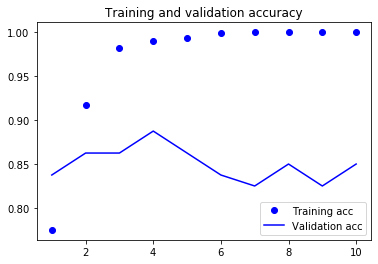

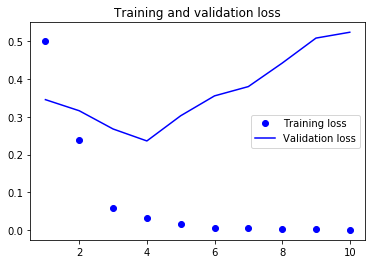

In [112]:
plot_scores(history_lstm)

Comparison of results  

I will use two functions to build a DataFrame for comparison.

In [113]:
# Function for converting the classification report results to a dataframe

def get_classification_report(y_true, y_pred):
    
    '''This function takes in true (y_true) and predicted (y_pred) values of a target variable and produces 
    a classification report '''
    
    metrics_summary = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred)

    avg = list(precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(list(metrics_summary), index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

In [114]:
# Function for adding explanatory columns and organizing the dataframe

def build_comparison_matrix(y_test, y_pred, algorithm, vector):
    
    '''This function builds a comparison matrix as a DataFrame, given target variable test and prediction values
    as pandas Series of integers, name of the algorithm of type string and name of the word vectorizer as string'''
    
    df = get_classification_report(y_test, y_pred)
    df['class']=['neg_review', 'pos_review', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = algorithm
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    
    return df

In [115]:
#For loop using above functions to build CountVectorizing results table

frames = [] # empty list for collecting dataframes

y_preds = [y_pred_w2v, y_pred_glove, y_pred_cnn, y_pred_lstm] 

labels = ['Word2Vec', 'GloVe', 'CNN', 'RNN_LSTM'] 

vector = 'Deep_Learning'

for y_pred, label in zip(y_preds, labels):
    df = build_comparison_matrix(y_test, y_pred, label, vector)
    frames.append(df)

# concatenating all dataframes
df_dnn = pd.concat(frames)

df_dnn2 = df_dnn.set_index(['vectorizer', 'model', 'accuracy', 'class'])

In [116]:
df_dnn2

precision    recall  f1-score  \
vectorizer    model    accuracy class                                       
Deep_Learning Word2Vec 0.737643 neg_review   0.531250  0.239437  0.330097   
                                pos_review   0.766234  0.921875  0.836879   
                                average      0.702797  0.737643  0.700067   
              GloVe    0.745247 neg_review   0.562500  0.253521  0.349515   
                                pos_review   0.770563  0.927083  0.841608   
                                average      0.714394  0.745247  0.708761   
              CNN      0.771863 neg_review   0.571429  0.619718  0.594595   
                                pos_review   0.854839  0.828125  0.841270   
                                average      0.778329  0.771863  0.774677   
              RNN_LSTM 0.832700 neg_review   0.728814  0.605634  0.661538   
                                pos_review   0.862745  0.916667  0.888889   
                                average      0.826589  0.832700  0.827513   

                                            support  
vectorizer    model    accuracy class                
Deep_Learning Word2Vec 0.737643 neg_review     71.0  
                                pos_review    192.0  
                                average       263.0  
              GloVe    0.745247 neg_review     71.0  
                                pos_review    192.0  
                                average       263.0  
              CNN      0.771863 neg_review     71.0  
                                pos_review    192.0  
                                average       263.0  
              RNN_LSTM 0.832700 neg_review     71.0  
                                pos_review    192.0  
                                average       263.0

Function for plotting F1 Scores of ML models

In [121]:
def f1_score_bar_plot(df, category, title):

    '''This function plots F1 scores from the given DataFrame and class'''
    
    plt.style.use('seaborn-pastel')
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('blue')
    b_plot[z].set_color('magenta')
    
    for i,v in enumerate(y_round):
        plt.text(i-.1, 0.018, str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean, ls='--', color='k', label=y_mean)
    plt.title(title)
    plt.legend(loc='upper right')
    
    return plt.show()

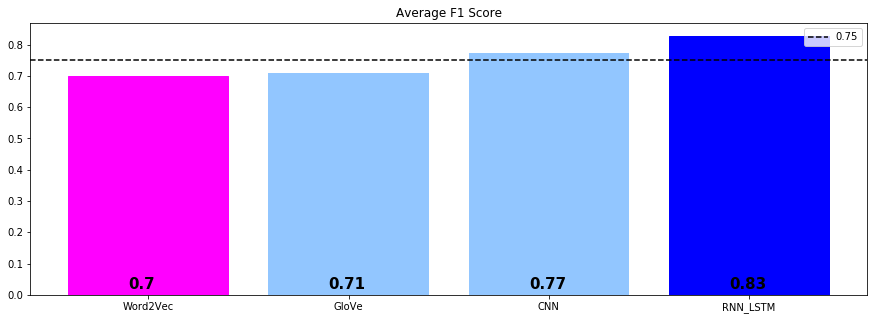

In [122]:
# Plotting F1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_dnn, category='average', title= "Average F1 Score")

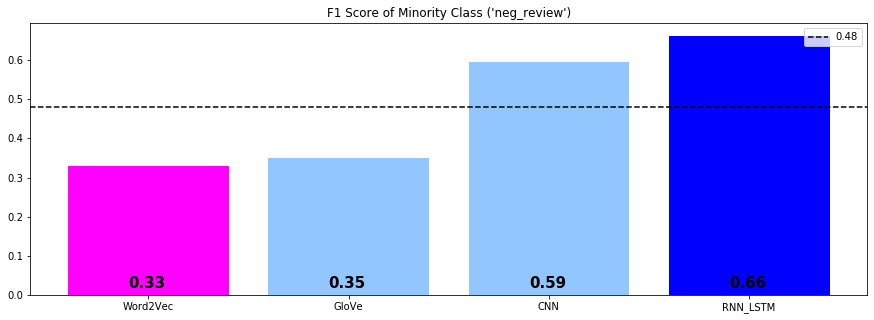

In [123]:
# Plotting F1 score of minority class ('neg_review') with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_dnn, category='neg_review', title= "F1 Score of Minority Class ('neg_review')")

- The best scores using deep learning models with Keras, both in average and minority class F1 score was made by RNN_LSTM: 0.83 and 0.66 respectively.  
- Word2Vec has the lowest average score of 0.7 and minority score of 0.33 
- I will save the results for further comparison. 

In [120]:
df_dnn2.to_csv('3h_Word2Vec_GloVe_CNN_RNN.csv', sep=',', encoding='utf-8')